In [1]:
import pylab as plt
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table, join

In [2]:
import seaborn as sns

This notebook uses all the raw data from the CIGALE predictions and photoz catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. 

In [3]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_SSDF/data/holes_SSDF_vista_ks_O16_20190207.fits')

## Read in CIGALE predictions catalogue

In [4]:
cigale=Table.read('../../dmu28/dmu28_SSDF/data/SSDF_Ldust_prediction_results.fits')

KeyboardInterrupt: 

In [ ]:
cigale['id'].name = 'help_id'

## Read in photoz

In [6]:
photoz=Table.read('../../dmu24/dmu24_SSDF/data/master_catalogue_ssdf_20180221_photoz_20180612_r_optimised.fits')

In [7]:
photoz

help_id,RA,DEC,id,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,za_hb,chi_r_eazy,chi_r_atlas,chi_r_cosmos,chi_r_stellar,stellar_type
bytes27,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6
HELP_J233046.211-554436.971,352.6925478135397,-55.7436030183174,3354518,0.4306,0.2345,0.6214,0.794,-99.0,-99.0,-99.0,-99.0,0.43829169565515985,0.2134987777777778,0.20562233333333332,0.35547,1.6260357142857145,rk5iii
HELP_J000428.390-544908.929,1.1182918048766741,-54.81914694924311,3354519,0.3603,0.2382,0.4732,0.789,-99.0,-99.0,-99.0,-99.0,0.3792211574271206,0.24826016666666664,1.4975116666666668,0.7845211666666666,14.168966666666668,m2iii
HELP_J230617.228-545328.558,346.5717848757397,-54.891266033293626,3354520,0.662,0.4,0.9406,0.789,0.2951,0.2913,0.299,0.001,0.631120927477367,0.2716274444444444,0.55524,0.4017435555555556,3.007298571428571,k5iii
HELP_J235832.822-561508.417,359.6367578747355,-56.25233804112545,3354521,0.1678,0.115,0.2271,0.788,-99.0,-99.0,-99.0,-99.0,0.1627349543459849,12.323577777777778,10.069453333333334,14.78808888888889,3.787782857142857,m0v
HELP_J234637.587-585945.798,356.6566139077836,-58.99605497697675,3354522,0.3602,0.2951,0.4297,0.64,0.4674,0.4383,0.4954,0.144,0.3546537780021313,32.63748888888889,22.70583333333333,24.749022222222223,3.921338571428571,m3v
HELP_J000430.911-514713.884,1.1287976875613008,-51.78719002265701,3354523,0.7543,0.636,0.8609,0.674,0.9201,0.8947,0.9464,0.094,0.795213132021387,7.430038333333333,7.107248333333334,5.843703333333334,1.3642273333333332,m4v
HELP_J235642.256-584052.673,359.17606484583314,-58.681297935010775,3354524,0.5717,0.3265,0.7898,0.789,0.2951,0.2913,0.299,0.002,0.568823299053812,0.1163200875,1.0550925,0.840755,1.0847035,m1iii
HELP_J232606.428-522708.917,351.5267848524185,-52.452477070078615,3354525,0.3033,0.2162,0.3834,0.791,-99.0,-99.0,-99.0,-99.0,0.3186207796877177,1.8005855555555554,0.7172803333333334,1.540791111111111,12.345702857142857,m0iii
HELP_J232652.351-514004.375,351.7181308281316,-51.667881913542985,3354526,0.2082,0.1627,0.2683,0.793,-99.0,-99.0,-99.0,-99.0,0.2089069038476353,19.133133333333333,14.482,16.02061111111111,3.9958057142857144,m1v


## Join CIGALE and photoz tables

In [ ]:
prior=join(cigale,photoz)

In [ ]:
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
f_pred=prior['bayes.dust.luminosity']/(4*np.pi*cosmo.luminosity_distance(prior['z1_median']).to(u.cm))

In [ ]:
prior=prior[np.isfinite(f_pred.value)][np.log10(f_pred.value[np.isfinite(f_pred.value)])>8.5]

In [ ]:
prior['DEC'].name='Dec'

In [13]:
len(cigale)

4436690

## Read in Maps

In [3]:
pswfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/SSDF_SPIRE250_v1.0.fits'#SPIRE 250 map
pmwfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/SSDF_SPIRE350_v1.0.fits'#SPIRE 350 map
plwfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/SSDF_SPIRE500_v1.0.fits'#SPIRE 500 map

#output folder
output_folder='./'

In [19]:
from astropy.io import fits
from astropy import wcs

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header
im250=hdulist[1].data*1.0E3 #convert to mJy
nim250=hdulist[3].data*1.0E3 #convert to mJy
cov250 = hdulist[4].data # seconds
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cdelt #pixel size (in arcseconds)
hdulist.close()

#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header
im350=hdulist[1].data*1.0E3 #convert to mJy
nim350=hdulist[3].data*1.0E3 #convert to mJy
cov350 = hdulist[4].data # seconds
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cdelt #pixel size (in arcseconds)
hdulist.close()

#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header
im500=hdulist[1].data*1.0E3 #convert to mJy
nim500=hdulist[3].data*1.0E3 #convert to mJy
cov500 = hdulist[4].data # seconds
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cdelt #pixel size (in arcseconds)
hdulist.close()

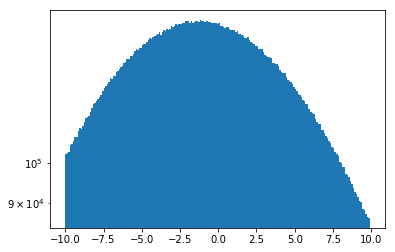

In [20]:
import matplotlib.pyplot as plt


plt.hist(im250.flatten(),bins=np.arange(-10.0,10.0,0.1));
plt.yscale('log')

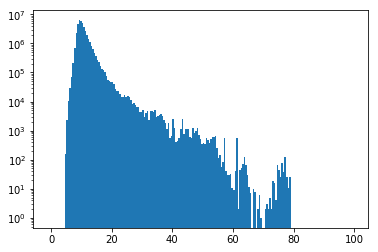

In [21]:

plt.hist(nim250.flatten(),bins=np.arange(-1.0,100.0,0.5));
plt.yscale('log')

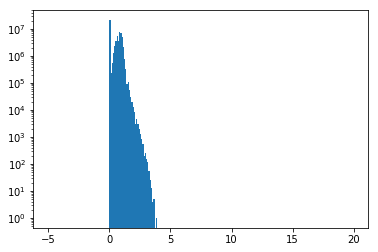

In [24]:

plt.hist(cov250.flatten(),bins=np.arange(-5.0,20.0,0.1));
plt.yscale('log')

In [ ]:
plt.scatter(cov250.flatten(), nim250.flatten())

In [25]:
np.where(~np.isnan(im250.flatten()))

(array([  423085,   423086,   423087, ..., 60155126, 60155127, 60155128]),)

In [28]:
im250.flatten()[423086]

31.191128300823507

In [29]:
nim250.flatten()[423086]

16.89809533517695

In [16]:
## Set XID+ prior class

In [17]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=Sel_func)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(prior['RA'] ,prior['Dec'] ,'SSDF_Ldust_prediction_results.fits',ID=prior['help_id'] )#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=Sel_func)
prior350.prior_cat(prior['RA'] ,prior['Dec'] ,'SSDF_Ldust_prediction_results.fits',ID=prior['help_id'] )
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=Sel_func)
prior500.prior_cat(prior['RA'] ,prior['Dec'] ,'SSDF_Ldust_prediction_results.fits',ID=prior['help_id'] )
prior500.prior_bkg(-5.0,5)

In [18]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0,1] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1,1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2,1] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [19]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=9
tiles=moc_routines.get_HEALPix_pixels(order,prior250.sra,prior250.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior250.sra,prior250.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./'
outfile=output_folder+'Master_prior.pkl'
xidplus.io.pickle_dump({'priors':[prior250,prior350,prior500],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},outfile)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 18279 tiles required for input catalogue and 379 large tiles
writing total_bytes=5118646130...
writing bytes [0, 1073741824)... done.
writing bytes [1073741824, 2147483648)... done.
writing bytes [2147483648, 3221225472)... done.
writing bytes [3221225472, 4294967296)... done.
writing bytes [4294967296, 5118646130)... done.


SystemExit: 

In [57]:
prior250.nsrc

1236678